In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
# Import Required Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

# Set Visualization Styles
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


# 1. Project Overview

In this notebook, we will analyze an e-commerce transactions dataset to segment customers based on their buying behavior. Using **RFM (Recency, Frequency, Monetary)** analysis paired with **K-Means clustering**, our goal is to uncover actionable customer segments that can drive targeted marketing strategies.

### Business Goals
- **Boost Customer Retention:** Identify high-value customers to nurture long-term loyalty.
- **Mitigate Churn:** Detect customers who are at risk of becoming inactive and implement re-engagement initiatives.
- **Optimize Marketing Efforts:** Customize campaigns based on detailed customer insights.
- **Drive Revenue Growth:** Enhance overall revenue by maximizing customer lifetime value (CLV).

### Dataset Snapshot
- **Source:** Kaggle - Ecommerce Transactions Dataset
- **Timeframe:** Transactions from 2010 to 2011
- **Key Features:**
  - **InvoiceNo:** Unique identifier for each transaction.
  - **StockCode:** Identifier for the products.
  - **Quantity:** Number of items purchased.
  - **InvoiceDate:** Date and time of purchase.
  - **UnitPrice:** Price per individual item.
  - **CustomerID:** Unique identifier for each customer.
  - **Country:** Customer's country of residence.

### Notebook Structure
1. **Data Cleaning & Preprocessing:** Tidy up the dataset by addressing missing values, data type issues, and outliers.
2. **Exploratory Data Analysis (EDA):** Uncover patterns and trends through visualizations and statistical summaries.
3. **Feature Engineering for RFM Analysis:** Compute Recency, Frequency, and Monetary metrics for each customer.
4. **Customer Segmentation with K-Means Clustering:** Group customers into distinct segments based on their RFM scores.
5. **Extract Customer IDs for CRM Integration:** Prepare segmented customer data for targeted marketing efforts.
6. **Business Insights & Strategic Recommendations:** Interpret the segmentation results to guide marketing and retention strategies.


# Data Acquisition & Initial Inspection

In [2]:
df= pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding="ISO-8859-1")

In [3]:
print("Loading first 5 Rows of the Data")
df.head()

Loading first 5 Rows of the Data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


Checking for Missing Values

In [5]:
print(df.isna().sum())
print(df.describe())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


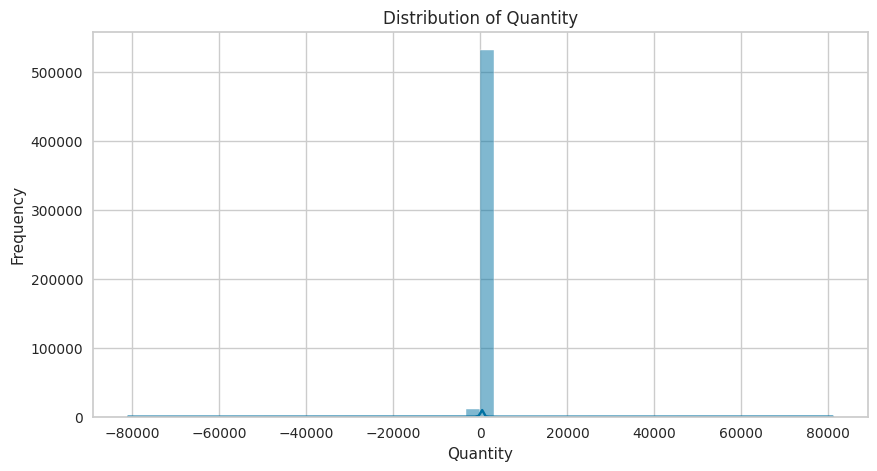

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


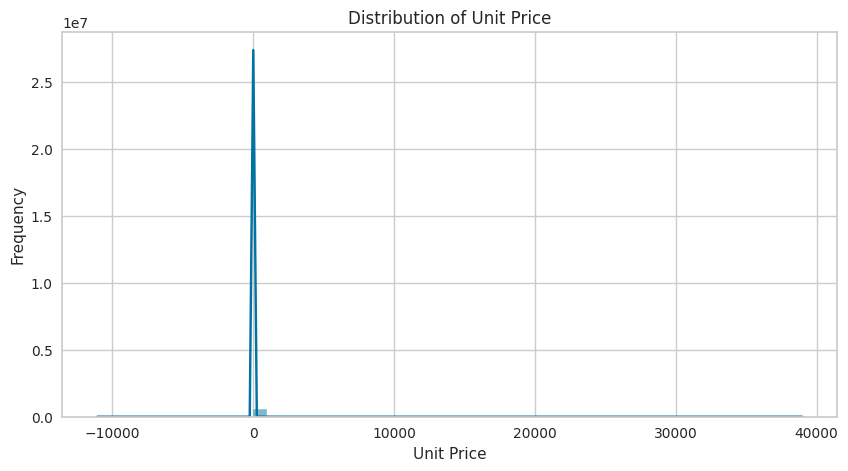

In [6]:
# Plotting histograms to detect outliers

# Histogram for Quantity
plt.figure(figsize=(10, 5))
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()

# Histogram for UnitPrice
plt.figure(figsize=(10, 5))
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title("Distribution of Unit Price")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.show()

# Key Observations from Data Acquisition & Initial Inspection

- **Missing CustomerID:**  
  Many rows lack a CustomerID, so we'll remove these records as they are critical for customer segmentation.

- **Negative Quantity Values:**  
  Some transactions show negative quantities (indicating returns or errors). These should be filtered out.

- **Negative Unit Price Values:**  
  Similarly, negative prices need to be addressed by either validating or removing those transactions.

- **InvoiceDate Stored as Text:**  
  The InvoiceDate column is currently in string format and must be converted to datetime format for proper time-based analysis.


# Data Cleaning & Preprocessing

In [7]:
# --- Handle Missing & Invalid Values ---
# Drop rows where CustomerID is missing (critical for segmentation)
df.dropna(subset=["CustomerID"], inplace=True)

# Convert CustomerID to integer for consistency
df["CustomerID"] = df["CustomerID"].astype(int)

# Remove transactions with negative quantities (returns/errors)
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"]>0]

# --- Data Type Conversion & Feature Engineering ---
# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["TotalPrice"] =  df["Quantity"]*df["UnitPrice"]

# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Check updated dataset info
print("\nData Info After Cleaning & Feature Engineering:")
df.info()

# --- Handling Infinite & NaN Values ---
# Check numeric columns for infinite values and replace them with NaN
numeric_cols = df.select_dtypes(include=[np.number])
if np.isinf(numeric_cols.to_numpy()).sum() > 0:
    print("Infinite values found. Replacing them with NaN...")
    df[numeric_cols.columns] = df[numeric_cols.columns].replace([np.inf, -np.inf], np.nan)

# Drop any remaining NaN values
df.dropna(inplace=True)

print("\nData Info After Removing Infinite and NaN Values:")
df.info()

# --- Memory Optimization ---
# Convert float64 to float32 and int64 to int32
for col in numeric_cols.columns:
    if df[col].dtype == "float64":
        df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
        df[col] = df[col].astype("int32")

print("\nFinal Dataset Info After Memory Optimization:")
df.info()


Data Info After Cleaning & Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB

Data Info After Removing Infinite and NaN Values:
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ---

# Final Summary

- ✔ **Handled missing & incorrect values:** Removed records with missing CustomerID and filtered out transactions with negative Quantity or UnitPrice.
- ✔ **Corrected data types:** Converted InvoiceDate to datetime and ensured all columns have appropriate data types.
- ✔ **Optimized memory usage:** Reduced the memory footprint by converting numerical columns to more efficient types.
- ✔ **Ensured data quality:** Produced a clean, accurate dataset ready for segmentation and deriving actionable insights.


#  Exploratory Data Analysis (EDA)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


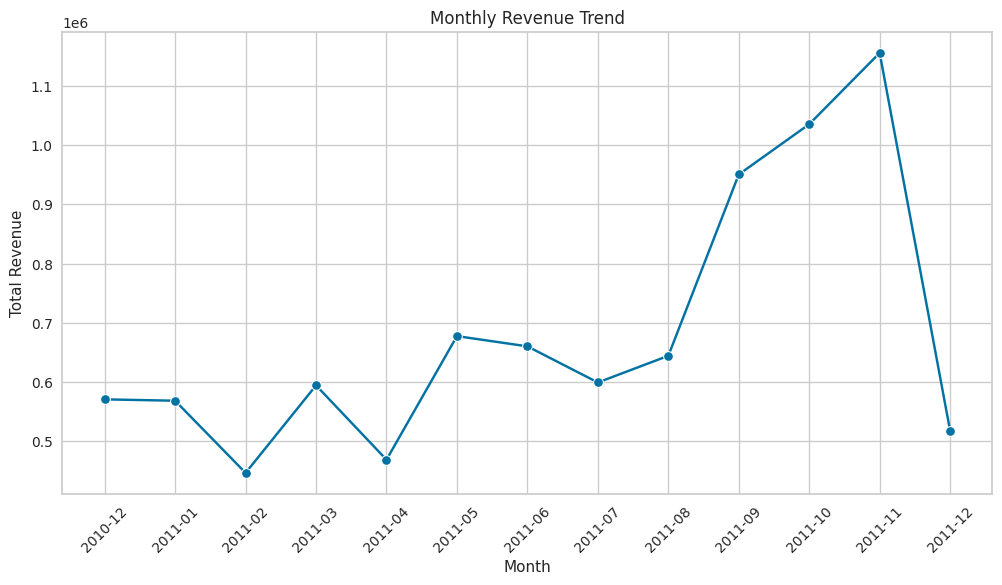

In [8]:
#Monthly Revenue Trends
df["Year_Month"]= df["InvoiceDate"].dt.to_period("M").astype("str")

# Aggregate revenue by month
monthly_revenue = df.groupby("Year_Month")["TotalPrice"].sum()

# Visualization: Monthly Revenue Trend
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_revenue.index.astype(str), y=monthly_revenue.values, marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

Holiday Shopping Surge

Early Ordering: Many customers start ordering gifts in November to ensure delivery before Christmas. This can create a spike in revenue leading into December.
Promotional Events: Even in the UK, Black Friday and Cyber Monday (though more prominent in recent years) could contribute to increased sales in November.
Partial December Data

The dataset runs until December 9, 2011, so the steep drop for December may simply reflect incomplete data for that month. If the full month were available, you might see another surge closer to Christmas.
Other Seasonal Factors

Limited Prominent Festivals: Outside of major holidays like Christmas, the dataset doesn’t show a similarly large peak in earlier months. Easter or Valentine’s Day might cause smaller upticks, but typically not at the scale of the year-end holiday season.
Business Model: The company sells “unique all-occasion gifts,” but Christmas remains the largest gift-giving event of the year, explaining the pronounced jump in late Q4.

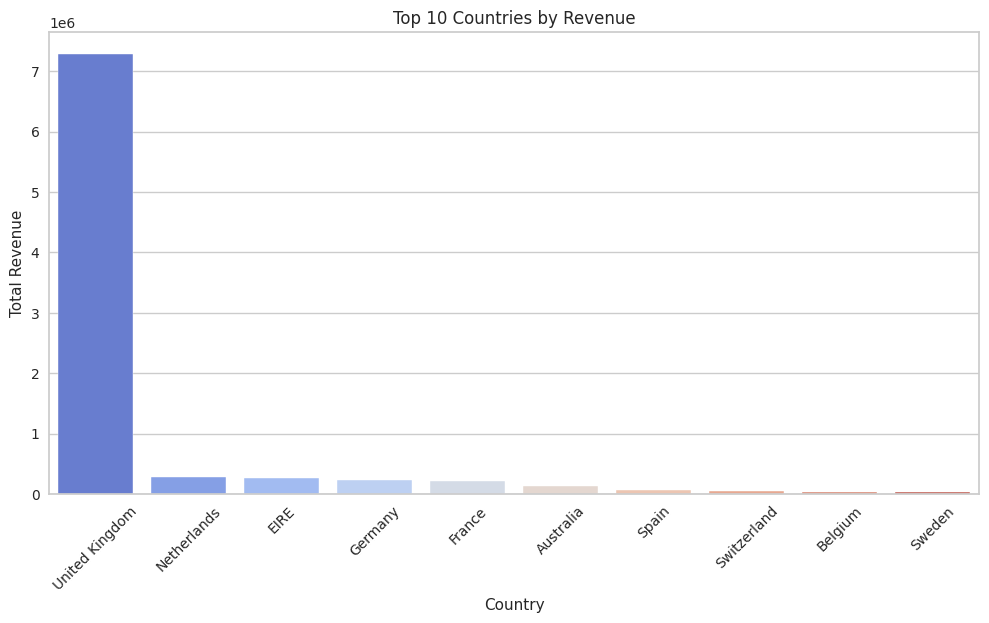

In [9]:
#Revenue by Country for Top 10 Countries

Revenue_by_Country= df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)
# Visualization: Revenue by Country
plt.figure(figsize=(12,6))
sns.barplot(x=Revenue_by_Country.index, y=Revenue_by_Country.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.show()



The chart clearly shows that the UK dominates revenue by a large margin, with the next highest revenues coming from other European countries like the Netherlands, EIRE (Ireland), Germany, and France. Since the company is based in the UK, several factors can explain why Europe accounts for most of the revenue:

Proximity & Logistics:

Shipping within Europe is generally faster and cheaper compared to overseas shipments, making European customers more likely to order in higher volumes.
Brand Awareness:

A UK-based company often has stronger brand recognition and marketing reach within Europe, leading to higher customer engagement in neighboring countries.
Regulatory & Currency Factors:

Within the EU/Europe, there can be fewer trade barriers (e.g., lower customs fees, simpler VAT processes) which encourages cross-border e-commerce.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


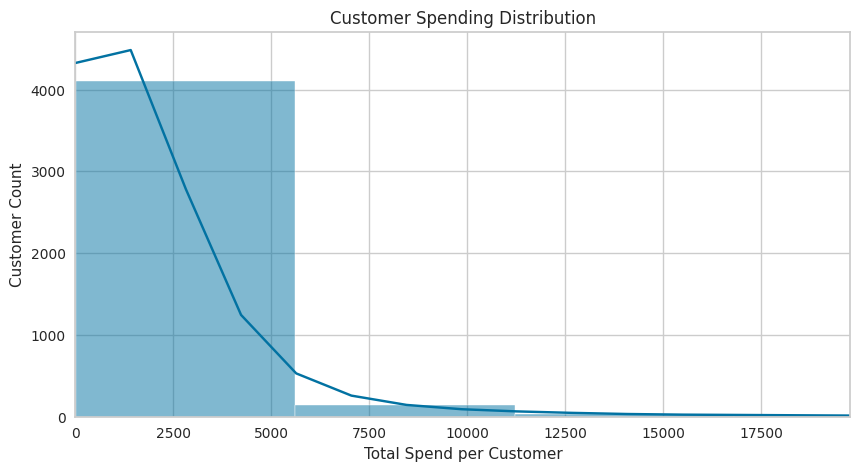

In [10]:
#Customer Spending Distribution
#Getting Spends of customers

customer_spend = df.groupby("CustomerID")["TotalPrice"].sum()
# Visualization: Customer Spending Distribution
plt.figure(figsize=(10,5))
sns.histplot(customer_spend, bins=50, kde=True)
plt.title("Customer Spending Distribution")
plt.xlabel("Total Spend per Customer")
plt.ylabel("Customer Count")
plt.xlim(0, customer_spend.quantile(0.99))  # Remove extreme outliers
plt.show()


Highly Skewed Distribution

The histogram shows that most customers have relatively low total spending, while a small number of customers account for much higher spending. This is a common pattern in e-commerce, often referred to as the Pareto principle (i.e., a small percentage of customers generate a large portion of the revenue).
Possible Explanations

Occasional vs. Frequent Buyers: Many customers might only make a few small purchases, whereas a select group might purchase frequently or in larger quantities.
Varied Product Mix: Low-spending customers might stick to lower-priced products, or simply buy less frequently. High-spending customers may purchase premium or bulk items, or shop more often.
Business Implications

Targeted Retention Strategies: A handful of “VIP” or high-spend customers could warrant special loyalty programs.
Reactivation Campaigns: The large pool of low-spend customers might respond to incentives or discounts aimed at increasing their purchase frequency.

In [11]:
#Product Level Sale Analysis

product_summary = df.groupby("Description").agg(
    total_quantity=("Quantity", "sum"),
    distinct_customers=("CustomerID", "nunique"),
    average_unit_price=("UnitPrice", "mean"),         # Reflects the price per item
    average_transaction_value=("TotalPrice", "mean")    # Reflects the revenue per transaction
).reset_index()

# Sort by total quantity sold for top-selling analysis
product_summary = product_summary.sort_values("total_quantity", ascending=False)

# Display top 10 products by quantity sold
print("Top 10 Selling Products:")
print(product_summary.head(10))


Top 10 Selling Products:
                             Description  total_quantity  distinct_customers  \
2319         PAPER CRAFT , LITTLE BIRDIE           80995                   1   
1992      MEDIUM CERAMIC TOP STORAGE JAR           77916                 138   
3786   WORLD WAR 2 GLIDERS ASSTD DESIGNS           54319                 307   
1762             JUMBO BAG RED RETROSPOT           46078                 635   
3698  WHITE HANGING HEART T-LIGHT HOLDER           36706                 856   
216        ASSORTED COLOUR BIRD ORNAMENT           35263                 678   
2269     PACK OF 72 RETROSPOT CAKE CASES           33670                 635   
2600                      POPCORN HOLDER           30919                 295   
2656                  RABBIT NIGHT LIGHT           27153                 450   
2047             MINI PAINT SET VINTAGE            26076                 213   

      average_unit_price  average_transaction_value  
2319            2.080000              16

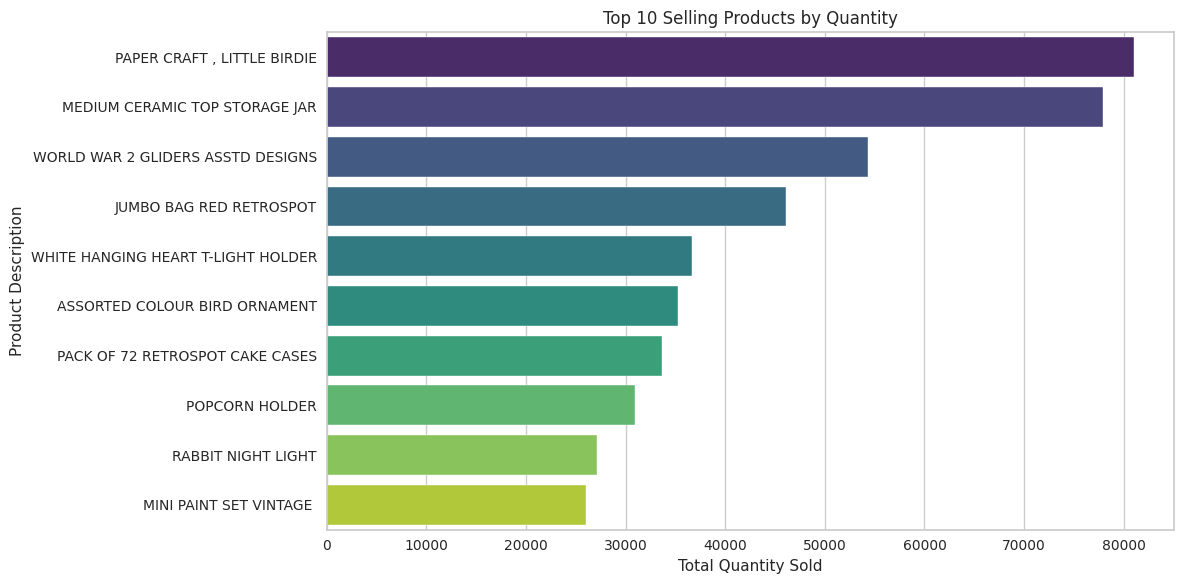

In [12]:
#Top Selling Products
plt.figure(figsize=(12, 6))
sns.barplot(data=product_summary.head(10), x="total_quantity", y="Description", palette="viridis")
plt.title("Top 10 Selling Products by Quantity")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()


Top 10 Most Expensive Products (by Average UnitPrice):
                             Description  total_quantity  distinct_customers  \
1036                      DOTCOM POSTAGE              16                   1   
2395      PICNIC BASKET WICKER 60 PIECES              61                   1   
2130                              Manual            6933                 197   
2885  RUSTIC  SEVENTEEN DRAWER SIDEBOARD              35                  21   
2769        REGENCY MIRROR WITH SHUTTERS              10                   7   
3555        VINTAGE BLUE KITCHEN CABINET              26                  17   
3604         VINTAGE RED KITCHEN CABINET              60                  34   
689        CHEST NATURAL WOOD 20 DRAWERS              24                  13   
1932       LOVE SEAT ANTIQUE WHITE METAL              58                  33   
3600         VINTAGE POST OFFICE CABINET              11                   2   

      average_unit_price  average_transaction_value  
1036      

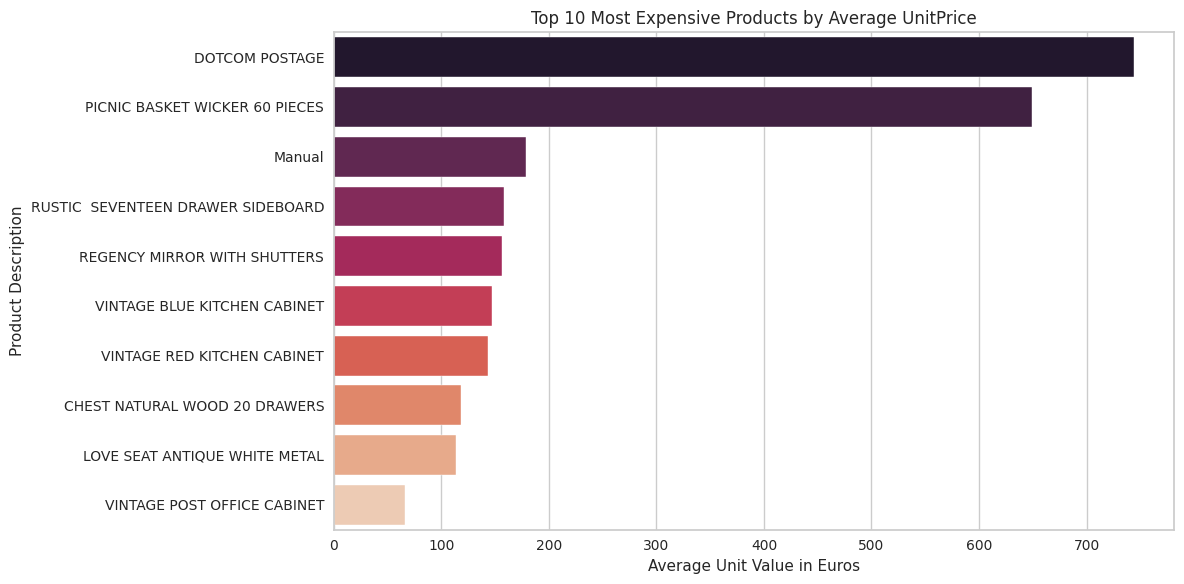

In [13]:
#Most Expensive Products
# Sort by average price for the most expensive products
expensive_products = product_summary.sort_values("average_unit_price", ascending=False)

print("Top 10 Most Expensive Products (by Average UnitPrice):")
print(expensive_products.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(data=expensive_products.head(10), x="average_unit_price", y="Description", palette="rocket")
plt.title("Top 10 Most Expensive Products by Average UnitPrice")
plt.xlabel("Average Unit Value in Euros")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()


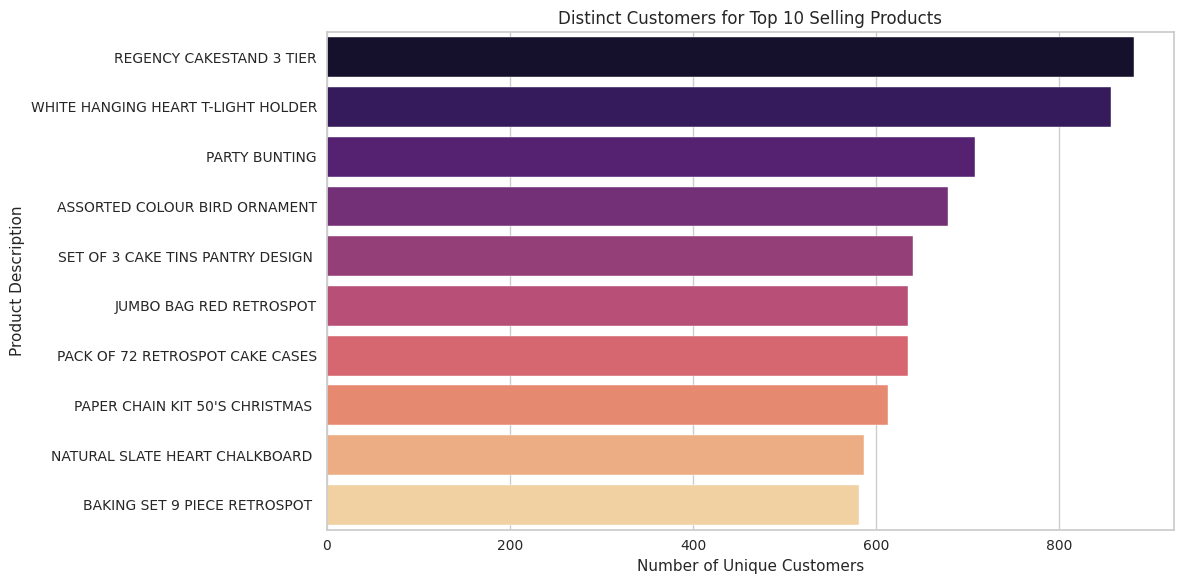

In [14]:
#Customer Reach per Product
plt.figure(figsize=(12, 6))
sns.barplot(data=product_summary.sort_values("distinct_customers",ascending=False).head(10), x="distinct_customers", y="Description", palette="magma")
plt.title("Distinct Customers for Top 10 Selling Products")
plt.xlabel("Number of Unique Customers")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()


Observations & Insights
Top Selling Product – “Paper Craft, Little Birdie”

Quantity: 80,995 units sold (the highest overall).
Distinct Customers: Only 1.

Interpretation:
This could indicate a single wholesale buyer or a special arrangement where one customer repeatedly purchases this item in bulk.

From a business perspective, it’s a huge volume but concentrated in just one account—potentially a risk if that buyer stops ordering.

Broadly Popular Products

“Medium Ceramic Top Storage Jar” (77,916 units, 138 customers) and “White Hanging Heart T-Light Holder” (36,706 units, 856 customers) are examples of high-volume items with multiple distinct customers.

Interpretation:
These products enjoy wider popularity across many customers.
They likely contribute to stable revenue streams given a broader customer base.

Most Expensive Product – “DOTCOM POSTAGE”

Average Unit Price: ~€744.15
Distinct Customers: 1

Interpretation:
This may not be a typical item but rather a shipping or custom charge.
Very high unit price with just one buyer suggests a niche or one-off situation, similar to the “Paper Craft” case in terms of concentration risk.
High-Price vs. High-Volume

High-Price Items (e.g., “PICNIC BASKET WICKER 60 PIECES”) have a much smaller customer base.
High-Volume Items (e.g., “JUMBO BAG RED RETROSPOT”) tend to have more customers but lower average prices.

Interpretation:
This pattern suggests that most customers gravitate toward more affordable products, while a handful of items command premium pricing but attract fewer buyers.
Customer Reach

Products like “White Hanging Heart T-Light Holder” and “Assorted Colour Bird Ornament” have hundreds of distinct customers.

Interpretation:
These items are widely appealing, possibly suitable for multiple use cases or easily giftable.
Average Transaction Value

Looking at average_transaction_value, many top-selling items (by quantity) do not have a particularly high revenue per sale—indicating that low or moderate prices paired with high purchase volume drive their success.

Interpretation:
The bulk of total revenue for these items likely comes from many small transactions rather than large individual purchases.

Business Implications
Diversify Customer Base for Key Items

Items dominated by a single buyer (e.g., “Paper Craft, Little Birdie”) carry a concentration risk. If that buyer stops purchasing, sales for that product drop dramatically.
Focus on Widely Popular Products

Products that are both high volume and have many distinct customers (like “Jumbo Bag Red Retrospot”) are lower risk and might be strong candidates for promotional campaigns or consistent stocking.
Pricing Strategy

High-priced items can yield significant revenue per transaction but attract fewer buyers.
Low to moderate-priced items tend to draw broader customer interest, which can be leveraged with upselling or bundling strategies.
Wholesale vs. Retail Segments

Items like “Paper Craft, Little Birdie” might be sold primarily to wholesale or B2B buyers. Consider segmenting wholesale vs. retail to tailor marketing and inventory decisions.

# Future Analysis

Customer Segmentation (RFM): To confirm if high-volume buyers for certain products are also high-value or frequent customers.

Basket Analysis: To see which products are often purchased together, potentially guiding cross-selling.

Seasonality Checks: Some of these items might see spikes around holidays or specific times of the year.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

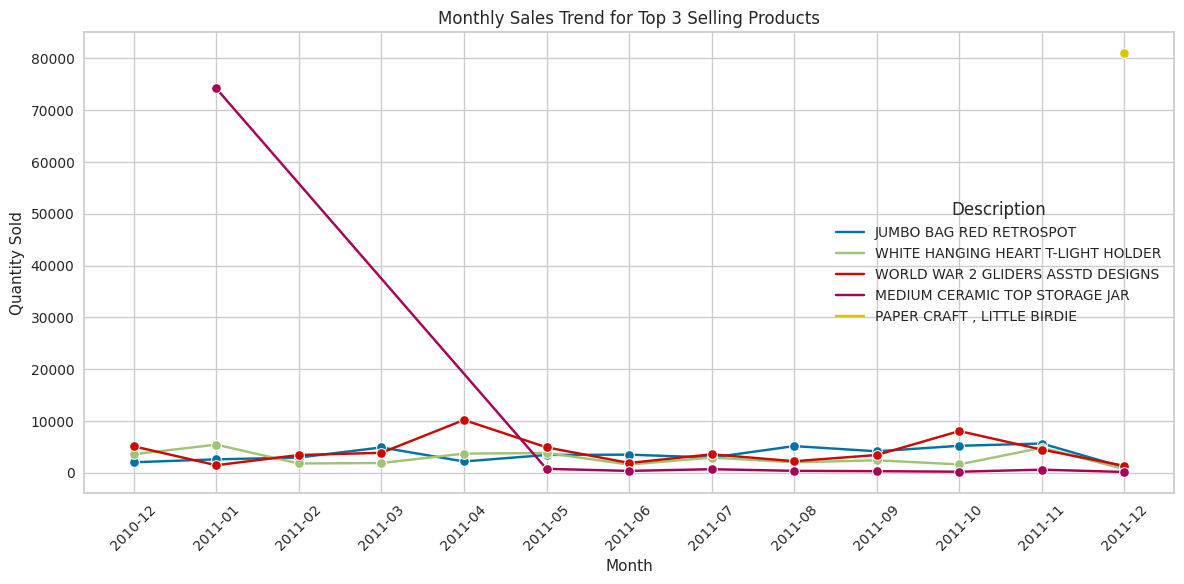

In [15]:
#Monthly Sales Trend for Top Products
# Identify top 3 selling products by quantity
top3_products = product_summary.head(5)["Description"].tolist()

# Filter dataset for these top 3 products
df_top3 = df[df["Description"].isin(top3_products)]

# Group by YearMonth and Description, summing the Quantity sold
monthly_sales = df_top3.groupby(["Year_Month", "Description"])["Quantity"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="Year_Month", y="Quantity", hue="Description", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend for Top 3 Selling Products")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()


The large spike for “Paper Craft, Little Birdie” in December 2010 might be one big wholesale order rather than a seasonal demand from many customers.

# RFM 
What is RFM?

RFM stands for Recency, Frequency, Monetary—three key metrics that define a customer’s engagement:

Recency (R):
How recently a customer made a purchase. The shorter the time since the last purchase, the more engaged the customer is likely to be.

Frequency (F):
How often a customer purchases. A higher purchase count suggests loyalty or strong engagement.

Monetary (M):
The total amount a customer has spent. This helps identify high-value customers who drive the most revenue.

Why RFM?

Identifies Valuable Customers:
You can distinguish loyal, high-value customers (low Recency, high Frequency, high Monetary) from at-risk or one-time buyers (high Recency, low Frequency, low Monetary).

Enables Targeted Marketing:
Instead of sending the same campaign to everyone, you can tailor promotions—e.g., VIP perks for top spenders, win-back offers for lapsed buyers.

Improves Retention & Revenue:
By understanding purchase patterns, you can boost customer lifetime value (CLV) and reduce churn through timely, personalized engagement.

Complements Product-Level Analysis:
Knowing which products sell best is important, but RFM tells you who is buying them, how often, and how recently. This holistic view is essential for strategic decision-making.

**How RFM Answers the “Who” Behind the Numbers** 

**High-Volume Buyers vs. High-Value Buyers:**
Product-level analysis might show a product selling in large quantities, but RFM reveals whether many different customers are each buying small amounts or a few customers are making large, frequent purchases.

**Retention vs. Acquisition Focus:**
By identifying customers with high Recency (recent purchases) but low Frequency, you can tailor campaigns to encourage repeat buying. Conversely, those with high Frequency but now have high Recency may be at risk of churn and need win-back offers.

**Personalized Offers:**
Segmenting your customer base by RFM scores allows you to create targeted promotions (e.g., exclusive perks for VIPs, reactivation discounts for lapsed customers) rather than one-size-fits-all marketing.



In [25]:
reference_date = df['InvoiceDate'].max()

# Group the data by CustomerID and calculate R, F, and M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
})

#  Rename the columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

#  Inspect the first few rows
print(rfm.head())

            Recency  Frequency      Monetary
CustomerID                                  
12346           325          1  77183.601562
12347             1          7   4310.000000
12348            74          4   1797.239990
12349            18          1   1757.550049
12350           309          1    334.399994


In [26]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,91.536422,4.272015,2048.687988
std,100.014169,7.697998,8985.225586
min,0.000000,1.000000,3.750000
25%,17.000000,1.000000,306.482491
50%,50.000000,2.000000,668.570007
75%,141.000000,5.000000,1660.597504
max,373.000000,209.000000,280206.031250


**Recency:**

**Definition:** Days since the customer’s last purchase (lower is better).

**Range:** From 0 to 373 days.

A value of 0 indicates a purchase on the very last day in your dataset.
A high value (e.g., 373) suggests the customer hasn’t purchased in over a year, putting them at risk of churn.

**Frequency:**

**Definition:** Number of unique purchases or invoices per customer.

**Range:** From 1 to 209.

1 means the customer only purchased once.
209 indicates a very frequent (or possibly bulk-buying) customer.

**Monetary:**

**Definition:** Total amount spent by the customer.

**Range:** From 0 to 280,206.03.

0 might indicate data anomalies (e.g., refunds or negative transactions) or a minimal purchase.
280k is exceptionally high, signifying a major contributor to your revenue.

# K-Means clustering

In [27]:
rfm_for_cluster = rfm[["Recency", "Frequency", "Monetary"]].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_cluster)


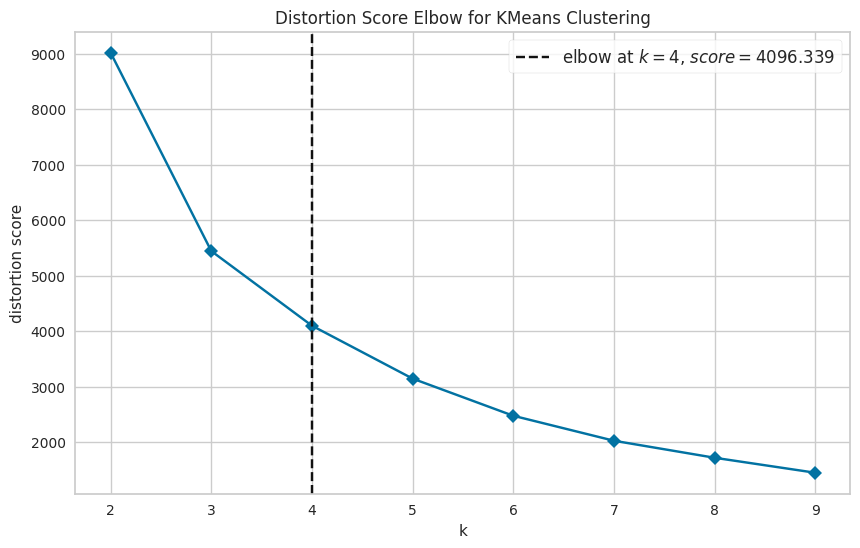

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
model = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)
visualizer.fit(rfm_scaled)
visualizer.show()


In [31]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

In [35]:
rfm = rfm.reset_index()

In [33]:
cluster_summary = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(2)
print(cluster_summary)


         Recency  Frequency       Monetary
Cluster                                   
0         247.56       1.55     476.329987
1          14.67      22.05   12435.089844
2           6.38      82.54  127187.960938
3          42.92       3.66    1344.719971


Based on these metrics, we can interpret the clusters as follows:

- **Cluster 0: Inactive/At-Risk Customers**  
  Customers in this group have not made a purchase for a long time, exhibit low purchase frequency, and have minimal total spend. They are likely dormant or at risk of churning.

- **Cluster 1: Regular Loyal Customers**  
  This group comprises active customers who purchase relatively frequently and have a moderate total spend, indicating steady engagement.

- **Cluster 2: VIP / High-Value Customers**  
  These customers are the most engaged, with very recent purchases, high purchase frequency, and the highest overall spend. They are crucial for driving revenue and should be targeted with exclusive offers.

- **Cluster 3: Occasional or Casual Buyers**  
  Customers here make purchases infrequently and spend less overall, representing a segment that might benefit from targeted promotions to increase their engagement.

These insights help us tailor marketing strategies to retain high-value customers (Cluster 2), re-engage at-risk customers (Cluster 0), and further encourage regular and occasional buyers (Clusters 1 and 3).

### Interpreting the Customer Segments

Using the average RFM values, we can define four distinct customer segments:

| **Segment Name**          | **Cluster ID** | **Key Characteristics**                                                   | **Recommended Strategy**                                                                                                  |
|---------------------------|----------------|---------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|
| **VIP / High-Value**      | 2              | Very low Recency, very high Frequency, and very high Monetary. These customers buy often, spend a lot, and purchased recently. | Offer exclusive perks, premium support, and personalized deals to retain and upsell.                                       |
| **Regular / Loyal**       | 1              | Low Recency, moderate Frequency, and moderate/high Monetary. Engaged buyers who make consistent purchases.                  | Provide loyalty programs, targeted cross-sells, and early access to new products.                                          |
| **Occasional / Casual**   | 3              | Moderate Recency, low Frequency, and moderate Monetary. These customers buy occasionally but aren’t fully engaged.         | Encourage more frequent purchases through promotions, bundling, and seasonal discounts.                                    |
| **Inactive / At-Risk**    | 0              | High Recency, low Frequency, and low Monetary. These customers haven’t purchased in a while and spend minimally.            | Run win-back campaigns with strong incentives, personalized reactivation emails, and special offers to encourage return.   |


**How to Implement These Strategies**

**Segmentation in CRM Systems:**
Integrate the RFM segments into your CRM platform to tailor communications and track customer responses.

**Automated Marketing Workflows:**
Use email automation to trigger reactivation or loyalty campaigns based on customer behavior.

**Performance Monitoring:**
Regularly analyze engagement metrics and conversion rates to refine strategies for each segment.

**A/B Testing:**
Test different offers, messaging, and campaign timing to determine what works best for each group.

In [36]:
# Create a dictionary to hold Customer IDs for each cluster
segment_dict = {}
for cluster in sorted(rfm["Cluster"].unique()):
    segment_ids = rfm.loc[rfm["Cluster"] == cluster, "CustomerID"].tolist()
    segment_dict[f"Cluster_{cluster}"] = segment_ids

# Print a summary of each segment
for cluster, ids in segment_dict.items():
    print(f"{cluster} has {len(ids)} customers.")

# Optionally, save the segmentation results (CustomerID and Cluster) to a CSV file
rfm[["CustomerID", "Cluster"]].to_csv("customer_segments.csv", index=False)
print("\nCustomer segmentation results saved as 'customer_segments.csv'")


Cluster_0 has 1062 customers.
Cluster_1 has 211 customers.
Cluster_2 has 13 customers.
Cluster_3 has 3052 customers.

Customer segmentation results saved as 'customer_segments.csv'


## Final Thoughts and Future Directions

This analysis demonstrates the power of RFM segmentation in understanding customer behavior and tailoring targeted marketing strategies. By identifying key customer segments—from VIPs to at-risk buyers—we can optimize retention efforts and maximize revenue.

**Future Research:**
- **Predictive Modeling:** Explore advanced machine learning techniques for churn prediction and lifetime value estimation.
- **Data Integration:** Combine online, offline, and social media data for a holistic customer view.
- **Personalization:** Develop real-time segmentation to drive dynamic pricing and personalized promotions.
- **Longitudinal Studies:** Continuously update RFM scores to monitor customer evolution and validate strategies over time.

These insights pave the way for practical business applications such as targeted marketing, loyalty program enhancements, and optimized resource allocation, ultimately driving a more customer-centric approach in the competitive e-commerce landscape.
